In [2]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-2a1faff5-55ca-46ee-907c-82c96452b812',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': 'cCWG4DC3cprFCMmIAxwLBosPq0F5hwxhmbdk-vP9jl5p'
}

configuration_name = 'os_1462fcc2681249aa94b0c0b6ac6659a0_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-vmt8c4cnyehyjq'))
df.take(1)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')]

In [3]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, col, lit, avg, count, sum, max, min, desc
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load and Clean Dataset

Load the medium dataset `medium-sparkify-event-data.json` (242.6MB) through IBM Watson Studio.

In [4]:
def clean_data(df):
    """
    Clean df
    
    INPUT:
        df - original df
        
    OUTPUT:
        df - clean df with valid userids, 
             replaced lengths with 0, 
             replaced artists and songs with None
    """
    df = df.filter(df.userId != '')
    df = df.fillna({'length':0, 'artist':'None', 'song':'None'})
    
    return df

In [5]:
df_valid = clean_data(df)

In [6]:
df_valid.count()

528005

In [7]:
df_valid.select('userId').dropDuplicates().count()

448

After cleaning, the dataset has 448 unique users with 528,005 valid events and 18 columns. 

# Feature Engineering

In [6]:
def extract_feature(df):
    """
    Extract features and create new columns
    
    INPUT:
        df - clean df
        
    OUTPUT:
        df - df with extracted features
    """
    # create a new column churn
    flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    df = df.withColumn('churnEvent', flag_churn_event('page'))

    windowval = Window.partitionBy('userId')
    df = df.withColumn('churn', max('churnEvent').over(windowval))
    
    # create a new column dataRange
    df = df.withColumn('dataRange', 
                       ((max('ts').over(windowval)-min('ts').over(windowval))/1000/3600/24).cast('int'))
    
    # create a new column countDown 
    df = df.withColumn('lastEvent', max('ts').over(windowval))
    df = df.withColumn('countDown', ((df.lastEvent-df.ts)/1000/3600/24).cast('int'))
    
    # filter data
    df = df.filter((df.dataRange >= 10) & (df.countDown <= 10))
    
    # create a new column thumbDown
    thrumb_down = udf(lambda x: 1 if x == 'Thumbs Down' else 0, IntegerType())
    df = df.withColumn('thumbDown', thrumb_down('page'))
    
    # create a new column downgrade
    downgrade = udf(lambda x: 1 if x == 'Downgrade' else 0, IntegerType())
    df = df.withColumn('downgrade', downgrade('page'))
    
    # create a new column ads
    roll_advert = udf(lambda x: 1 if x == 'Roll Advert' else 0, IntegerType())
    df = df.withColumn('ads', roll_advert('page'))
    
    return df

In [7]:
df_model = extract_feature(df_valid)

In [8]:
def engineer_feature(df):
    """
    Create a new df with engineered features for model training
    
    INPUT:
        df - df containing extracted features
        
    OUTPUT:
        data - new df with engineered features
    """
    # convert gender to numerical values F: 0, M: 1
    df_gender = df \
        .select('userId','gender').dropDuplicates() \
        .replace({'F':'0', 'M':'1'}, subset='gender') \
        .select('userId', col('gender').cast('int'))
    
    # extract days being a user
    df_servicedays = df \
        .select('userId','churn','registration','ts') \
        .withColumn('serviceDays', (df.ts - df.registration)) \
        .groupby('userId','churn').agg({'serviceDays':'max'}) \
        .select('userId','churn',(col('max(serviceDays)')/1000/3600/24).cast('int').alias('serviceDays'))
    
    # extract number of thumbs down
    df_thumbdown = df \
        .select('userId','thumbDown') \
        .groupby('userId').agg({'thumbDown':'sum'}) \
        .withColumnRenamed('sum(thumbDown)','numThumbdown')
    
    # extract number of downgrades
    df_downgrade = df \
        .select('userId','downgrade') \
        .groupby('userId').agg({'downgrade':'sum'}) \
        .withColumnRenamed('sum(downgrade)','numDowngrade')
    
    # extract number of ads
    df_ads = df \
        .select('userId','ads') \
        .groupby('userId').agg({'ads':'sum'}) \
        .withColumnRenamed('sum(ads)','numAds')
    
    # combine all features, drop userId and rename churn with label
    data = df_gender.join(df_servicedays, 'userID') \
        .join(df_thumbdown, 'userID') \
        .join(df_downgrade, 'userID') \
        .join(df_ads, 'userID') \
        .drop('userID') \
        .withColumnRenamed('churn','label')
    
    return data

In [9]:
data = engineer_feature(df_model)

# Modeling

In [19]:
# build a pipeline to preprocess the data
def preprocess(data):
    """
    Preprocess data for model training: log transformation, 
                                        combine features, 
                                        standardize vectors, 
                                        split data
    
    INPUT:
        data - data containing label and features
    
    OUTPUT:
        train, test sets
    """
    # apply log transformation to numAds, numDowngrade and numThumbdown
    data_pd = data.toPandas()
    to_trans = ['numAds', 'numDowngrade', 'numThumbdown']

    for col in to_trans:
        data_pd[col] = data_pd[col].astype('float64').replace(0.0, 0.01) 
        data_pd[col] = np.log(data_pd[col])
    
    # convert df to spark df
    data = spark.createDataFrame(data_pd)
    
    # combine features to a vector
    cols = data.drop('label').columns
    assembler = VectorAssembler(inputCols=cols, outputCol='numFeatures')
    data = assembler.transform(data)

    # standardize the vectors
    scaler = StandardScaler(inputCol='numFeatures', outputCol='features', withStd=True)
    scalerModel = scaler.fit(data)
    data = scalerModel.transform(data)
    
    train, test = data.randomSplit([0.8, 0.2], seed=42)
    
    return train, test

In [20]:
train, test = preprocess(data)

In [12]:
def model_eval(result, evaluator, test_set):
    """
    Display accuracy, recall and F1 score of test set
    
    INPUT:
        result - result containing predictions (df)
        evaluator - evaluator
        test_set - name of dataset used in prediction (str)
    """    
    accuracy = evaluator.evaluate(result, {evaluator.metricName: 'accuracy'})
    recall = evaluator.evaluate(result, {evaluator.metricName: 'weightedRecall'})
    f1 = evaluator.evaluate(result, {evaluator.metricName: 'f1'})
    
    print(f'\nAccuracy of {test_set} set: {accuracy}')
    print(f'Recall of {test_set} set: {recall}')
    print(f'F1 score of {test_set} set: {f1}')

In [13]:
def build_model(model, model_name):
    """
    Build a model with 3-fold cross validation and display the evaluation result
    
    INPUT:
        model - model with parameters
        model_name - name of the classifier (str)
    
    OUTPUT:
        trained_model - trained model
    """
    # initialize model
    model = model

    # build paramGrid
    paramGrid = ParamGridBuilder().build()

    crossval_model = CrossValidator(estimator=model,
                                    estimatorParamMaps=paramGrid,
                                    evaluator=MulticlassClassificationEvaluator(),
                                    numFolds=3)

    # train the training set and calculate training time
    start = time.time()
    trained_model = crossval_model.fit(train)
    end = time.time()
    train_time = end - start

    # predict the traing and validation set
    evaluator = MulticlassClassificationEvaluator()
    result_train = trained_model.transform(train)
    result_test = trained_model.transform(test)
    
    print(f'{model_name}')
    print(f'\nTraining time: {train_time} seconds')
    model_eval(result_train, evaluator, 'train')
    model_eval(result_test, evaluator, 'test')
    
    return trained_model

### Baseline model

In [21]:
baseline = test.withColumn('prediction', lit(0.0))
evaluator = MulticlassClassificationEvaluator()
model_eval(baseline, evaluator, 'test')


Accuracy of test set: 0.8023255813953488
Recall of test set: 0.8023255813953488
F1 score of test set: 0.7143285821455364


### Final model

In [22]:
clf = LogisticRegression()

paramGrid = ParamGridBuilder() \
    .addGrid(clf.maxIter, [10,20]) \
    .addGrid(clf.regParam, [0.0,0.1]) \
    .build()

crossval = CrossValidator(estimator=clf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(), 
                          numFolds=3)

In [23]:
start = time.time()
cvModel = crossval.fit(train)
end = time.time()

print(f'Tuning time: {end - start} seconds')
cvModel.avgMetrics

Tuning time: 20.547040224075317 seconds


[0.7593869476423635,
 0.7553979306175745,
 0.7593869476423635,
 0.7553979306175745]

In [24]:
evaluator = MulticlassClassificationEvaluator()
final_result = cvModel.transform(test)
model_eval(final_result, evaluator, 'test')


Accuracy of test set: 0.813953488372093
Recall of test set: 0.813953488372093
F1 score of test set: 0.7409309037216014


In [25]:
best_model = cvModel.bestModel

### Feature Importance

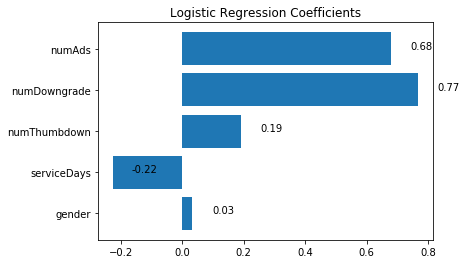

In [27]:
cols = data.drop('label').columns
coefficients = best_model.coefficients.values
locs = np.arange(len(coefficients)) + 0.5
labels = np.array(cols)

plt.barh(locs, coefficients, align='center')
plt.yticks(locs, labels)
# Add annotation
for loc, coeff in zip(locs, coefficients):
    s = f'{coeff:0.2f}'
    plt.text(y=loc, x=coeff+0.1, s=s, ha='center')
        
plt.xlabel('')
plt.title('Logistic Regression Coefficients');

In [28]:
cvModel.save('best_gbt')